In [60]:
import pandas as pd
import numpy as np
import os # For potential file path operations

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import scikit-learn utilities
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
#from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, classification_report
from sklearn.feature_selection import RFE, SelectFromModel

# Import models (add more as needed)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
# from xgboost import XGBClassifier # Uncomment if XGBoost is installed and needed
# from lightgbm import LGBMClassifier # Uncomment if LightGBM is installed and needed

# Import imbalanced-learn for handling imbalance
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from imblearn.pipeline import Pipeline
# Import model explainability libraries
#import shap
import joblib # For saving/loading models

# Import utility for ignoring warnings
import warnings



# Define a random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED) # Set seed for numpy



# Configure settings
warnings.filterwarnings('ignore') # Suppress warnings for cleaner output


sns.set_theme(style="whitegrid")

## Business Understanding & Problem Definition
- Problem Statement: Customer churn, in the context of this telecom company, refers to the phenomenon where existing customers discontinue their service subscriptions (e.g., phone, internet) within a defined period (typically implied as recent or near-future based on the dataset).

- Business Goal: The primary business goal is to proactively identify customers who are at high risk of churning. By predicting churn, the company aims to:

- Reduce Revenue Loss: Retaining existing customers is significantly more cost-effective than acquiring new ones. Reducing churn directly protects the revenue base.

- Enable Targeted Retention Efforts: Identifying high-risk customers allows the company to implement specific, potentially costly, retention strategies (e.g., discounts, service upgrades, proactive support) only for those who need them most, maximizing ROI.

- Improve Customer Satisfaction: Understanding the drivers of churn can highlight systemic issues with services, pricing, or support, leading to broader improvements that benefit all customers.

- ML Objective: The machine learning objective is to build a binary classification model. This model will predict whether a given customer will churn (Yes) or not (No) based on their demographic information, account details, and service usage patterns.

- Target Variable: The target variable is the Churn column in the dataset. We will likely encode this as 1 for 'Yes' (churn) and 0 for 'No' (no churn).

- Key Evaluation Metric: Given the business goal of proactive retention, Recall (Sensitivity) for the 'Yes' (Churn) class is arguably the most critical metric.

- Justification: Missing a customer who is actually going to churn (a False Negative) means losing that customer and their associated revenue without attempting intervention. This is often considered more costly than mistakenly targeting a non-churning customer with a retention offer (a False Positive), although the cost of retention efforts must also be considered. While Recall is primary, we will also closely monitor Precision (to understand the efficiency of retention campaigns) and the F1-Score (as a balance between Recall and Precision), along with ROC-AUC (to gauge the model's overall ability to distinguish between the two classes). The ultimate choice might involve threshold tuning to optimize for the desired balance based on specific campaign costs and customer value.

In [61]:
DATA_FILE_PATH = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'

df = pd.read_csv(DATA_FILE_PATH)

In [62]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7043.0,NaN,NaN,NaN,32.371149,24.559481,0.0,9.0,29.0,55.0,72.0
PhoneService,7043,2,Yes,6361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,7043,3,No,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7043,3,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,7043,3,No,3498,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## EDA

In [63]:
df['Churn'].value_counts(normalize=True)

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

In [64]:
pd.to_numeric(df['Contract'], errors='coerce')
df.drop(columns='customerID')

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


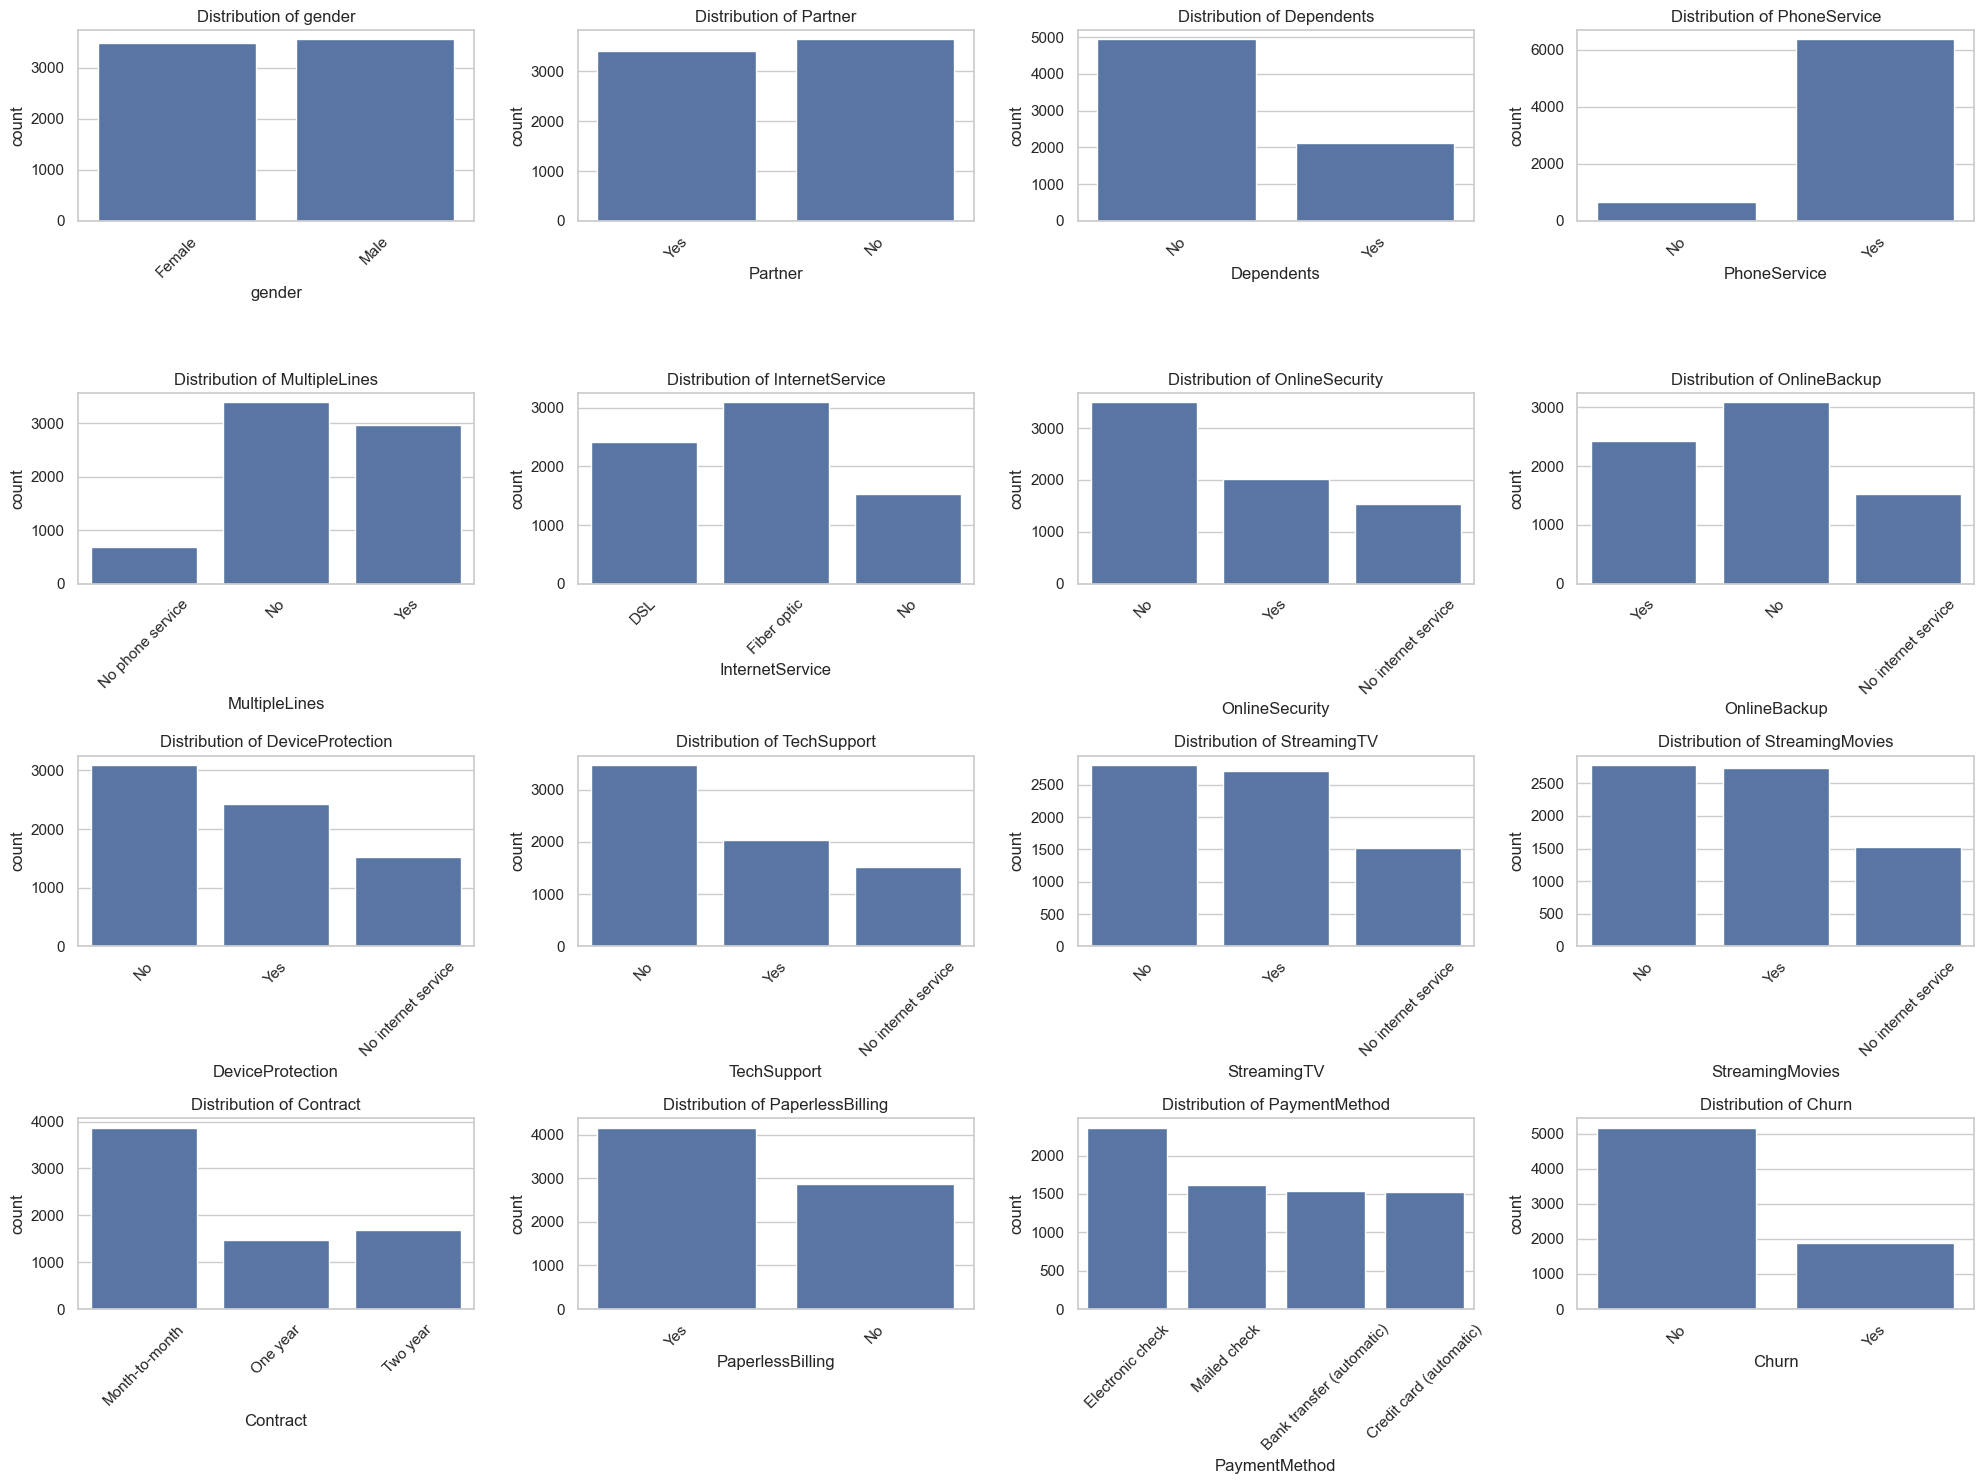

In [65]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
max_plots_per_figure = 16  # 4x4 grid
num_figures = (len(categorical_cols) + max_plots_per_figure - 1) // max_plots_per_figure

# Filter out customerID and TotalCharges from categorical columns
categorical_cols = [col for col in categorical_cols if col not in ['customerID', 'TotalCharges']]

plt.figure(figsize=(20, 15))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(4, 4, i)
    sns.countplot(x=col, data=df)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

<Axes: xlabel='Churn', ylabel='tenure'>

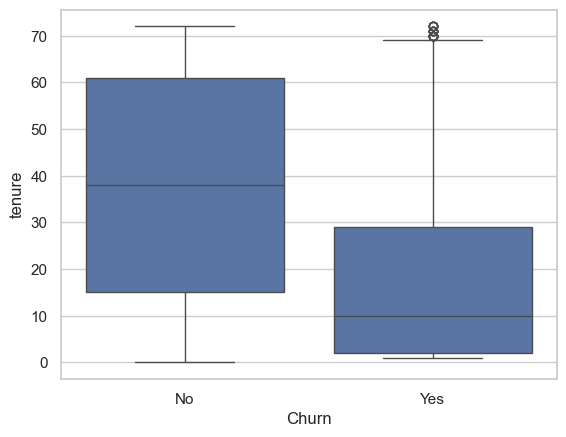

In [66]:
sns.boxplot(x='Churn', y='tenure', data=df)

<Axes: xlabel='MonthlyCharges', ylabel='Density'>

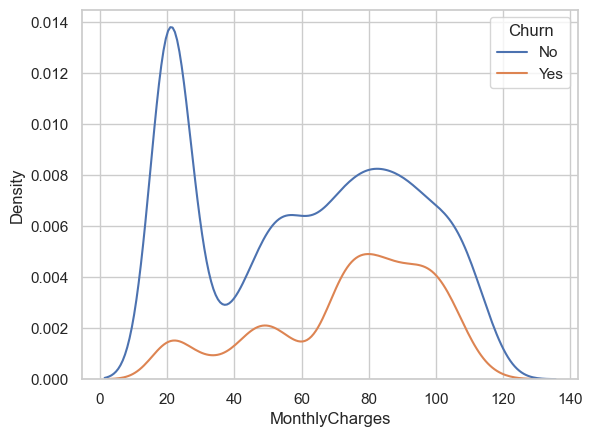

In [67]:
sns.kdeplot(data=df, x='MonthlyCharges', hue='Churn')

<Axes: xlabel='Contract', ylabel='count'>

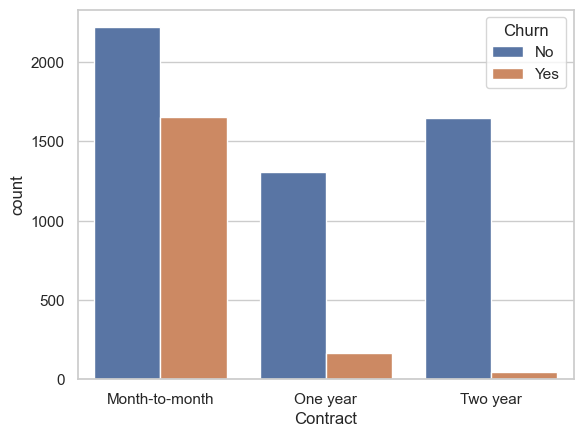

In [68]:
sns.countplot(x='Contract', hue='Churn', data=df)

## Data Processing

In [69]:
# Convert 'TotalCharges' to numeric, coercing errors (e.g., spaces) to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop customerID as it's not a predictive feature
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)
    print("Dropped 'customerID' column.")

# Check for NaNs created by coercion
print(f"\nNaNs in TotalCharges after conversion: {df['TotalCharges'].isnull().sum()}")

Dropped 'customerID' column.

NaNs in TotalCharges after conversion: 11


In [70]:
df['TotalCharges_temp'] = df['TotalCharges'].fillna(df['MonthlyCharges']) # Temporary fill for calculation

# 1. Tenure Ratio (MonthlyCharges / TotalCharges) - Careful with zero tenure/charges
# Add small epsilon to avoid division by zero or infinity issues
epsilon = 1e-6
# Use tenure + epsilon to avoid dividing by zero for new customers
df['MonthlyToTotalRatio'] = df['MonthlyCharges'] / (df['TotalCharges_temp'] + epsilon)
# For customers with 0 tenure, this ratio might not be meaningful or could be infinite/large.
# Let's cap or adjust it. If tenure is 0, maybe ratio isn't applicable or is 1?
df.loc[df['tenure'] == 0, 'MonthlyToTotalRatio'] = 1 # Assuming monthly is the total if tenure=0

# 2. Number of Additional Services (beyond basic phone/internet)
# Define services that are considered 'additional'
additional_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                       'TechSupport', 'StreamingTV', 'StreamingMovies']
# Count how many 'Yes' values exist across these columns
# Replace 'No internet service' with 'No' temporarily for easier counting
df_temp_services = df[additional_services].replace('No internet service', 'No')
df['NumAdditionalServices'] = df_temp_services[df_temp_services == 'Yes'].count(axis=1)

# 3. Has Internet Service (Binary)
df['HasInternetService'] = np.where(df['InternetService'] == 'No', 0, 1)

# Clean up temporary columns
df.drop('TotalCharges_temp', axis=1, inplace=True)
print(df[['MonthlyToTotalRatio', 'NumAdditionalServices', 'HasInternetService']].head())
print(f"New shape after FE: {df.shape}")


   MonthlyToTotalRatio  NumAdditionalServices  HasInternetService
0             1.000000                      1                   1
1             0.030140                      2                   1
2             0.497920                      2                   1
3             0.022980                      3                   1
4             0.466205                      0                   1
New shape after FE: (7043, 23)


In [71]:
X = df.drop('Churn', axis=1)
y = df['Churn'].map({'Yes': 1, 'No': 0})

print("\n--- Features (X) ---")
print(X.head())
print("\n--- Target (y) ---")
print(y.head())
print(f"Target value counts:\n{y.value_counts()}")


--- Features (X) ---
   gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  ...  \
0  No phone service             DSL             No          Yes  ...   
1                No             DSL            Yes           No  ...   
2                No             DSL            Yes          Yes  ...   
3  No phone service             DSL            Yes           No  ...   
4                No     Fiber optic             No           No  ...   

  StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No              No  Month-to-month              Yes   
1   

In [72]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,        # 20% for the test set
    random_state=RANDOM_SEED, # Use the defined random seed
    stratify=y            # Ensure class distribution is similar in train/test
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Churn distribution in y_train:\n{y_train.value_counts(normalize=True)}")
print(f"Churn distribution in y_test:\n{y_test.value_counts(normalize=True)}")

X_train shape: (5634, 22)
X_test shape: (1409, 22)
y_train shape: (5634,)
y_test shape: (1409,)
Churn distribution in y_train:
Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64
Churn distribution in y_test:
Churn
0    0.734564
1    0.265436
Name: proportion, dtype: float64


In [73]:
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'SeniorCitizen' in numerical_features:
    numerical_features.remove('SeniorCitizen') # Remove if present

categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
# Add 'SeniorCitizen' to categorical features
categorical_features.append('SeniorCitizen')

# Include newly engineered features if they are numeric
engineered_numeric = ['MonthlyToTotalRatio', 'NumAdditionalServices', 'HasInternetService']
for feat in engineered_numeric:
    if feat in X_train.columns and feat not in numerical_features:
         # Check if it's actually numeric in the DataFrame
         if pd.api.types.is_numeric_dtype(X_train[feat]):
              numerical_features.append(feat)
    # If engineered features were object type, they'd be caught by select_dtypes('object')


print(f"Numerical features ({len(numerical_features)}): {numerical_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

Numerical features (6): ['tenure', 'MonthlyCharges', 'TotalCharges', 'MonthlyToTotalRatio', 'NumAdditionalServices', 'HasInternetService']
Categorical features (16): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']


In [74]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Create the preprocessor object using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any)
)

In [75]:
# This learns the medians, scales, and categories from X_train
preprocessor.fit(X_train)
print("Preprocessor fitted on X_train.")

# Transform both the training and testing data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

Preprocessor fitted on X_train.


## Modeling & Evaluation

### Basic Logistic Regression

In [76]:
baseline_lr_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('resampler', None), # No resampling for this baseline check
    ('classifier', LogisticRegression(random_state=RANDOM_SEED, max_iter=1000))
])
baseline_lr_pipe.fit(X_train_processed, y_train)
y_pred_lr_base = baseline_lr_pipe.predict(X_test_processed)
y_pred_proba_lr_base = baseline_lr_pipe.predict_proba(X_test_processed)[:, 1]

print("\nBasic Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr_base))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_lr_base):.4f}")



ValueError: Specifying the columns using strings is only supported for dataframes.

### Random Forrest

In [ ]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
scoring_metric = 'f1' # Optimize for F1 during search (balance)
n_iterations = 50 # Number of parameter settings that are sampled (adjust as needed)

# --- Random Forest Tuning ---

# Define the base pipeline structure for Random Forest
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('resampler', None), # Placeholder for resampling techniques
    ('classifier', RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1))
])

# Define parameter ranges for Random Forest classifier
rf_param_ranges = {
    'classifier__n_estimators': [100, 200, 300, 400],
    'classifier__max_depth': [5, 10, 15, 20, None],
    'classifier__max_features': ['sqrt', 'log2', 0.3], # Use 'sqrt' instead of 'auto'
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 3, 5],
    'classifier__bootstrap': [True, False]
    # 'classifier__criterion': ['gini', 'entropy'] # Can add if desired
}

# Define resampling options to test
resampling_options = [
    (None, {}), # No resampling
    (SMOTE(random_state=RANDOM_SEED), {'resampler__k_neighbors': [3, 5, 7]}),
    (RandomUnderSampler(random_state=RANDOM_SEED), {'resampler__sampling_strategy': [0.3, 0.5, 0.7]}),
    (RandomOverSampler(random_state=RANDOM_SEED), {'resampler__sampling_strategy': [0.5, 0.7, 1.0]}),
    # Add more like ADASYN, SMOTEENN if desired
    # (ADASYN(random_state=RANDOM_SEED), {'resampler__n_neighbors': [3, 5, 7]}),
    # (SMOTEENN(random_state=RANDOM_SEED), {})
]

# Create the parameter grid list for RandomizedSearchCV
param_grid_rf = []
for resampler, resampler_params in resampling_options:
    # Base config for this resampler
    config = {
        'resampler': [resampler],
        **rf_param_ranges # Add classifier ranges
    }
    # Add specific parameters for the current resampler
    config.update(resampler_params)

    # Add class_weight options (test only when NO external resampling is active)
    if resampler is None:
         config['classifier__class_weight'] = [None, 'balanced', 'balanced_subsample']
    else:
         config['classifier__class_weight'] = [None] # Don't use internal weighting with external resampling

    param_grid_rf.append(config)


# Setup RandomizedSearchCV for Random Forest
random_search_rf = RandomizedSearchCV(
    pipeline_rf,
    param_distributions=param_grid_rf,
    n_iter=n_iterations,
    scoring=scoring_metric,
    refit=scoring_metric, # Refit the best estimator found using the whole training set
    cv=cv_strategy,
    verbose=1,
    n_jobs=-1, # Use all available CPU cores
    random_state=RANDOM_SEED
)

print(f"\nStarting RandomizedSearchCV for RandomForest (n_iter={n_iterations})...")

random_search_rf.fit(X_train_processed, y_train)



Starting RandomizedSearchCV for RandomForest (n_iter=50)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('resampler', None),
                                             ('classifier',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions=[{'classifier__bootstrap': [True, False],
                                         'classifier__class_weight': [None,
                                                                      'balanced',
                                                                      'balanced_subsample'],
                                         'classifier__m...
                                         'classifier__max_depth': [5, 10, 15,
                                                                   20, None],
                                         'classifier__max_features': ['sqrt',
                                                                      'log2',
                                                                      0.3],
                                         'classifier__min_samples_leaf': [1, 3,
                                                                          5],
                                         'classifier__min_samples_split': [2, 5,
                                                                           10],
                                         'classifier__n_estimators': [100, 200,
                                                                      300,
                                                                      400],
                                         'resampler': [RandomOverSampler(random_state=42)],
                                         'resampler__sampling_strategy': [0.5,
                                                                          0.7,
                                                                          1.0]}],
                   random_state=42, refit='f1', scoring='f1', verbose=1)

In [28]:
print(random_search_rf.best_params_)
print(f"\nBest Cross-Validation {scoring_metric.upper()} Score (Random Forest): {random_search_rf.best_score_:.4f}")

# Store the best RF estimator
best_rf_pipeline = random_search_rf.best_estimator_


{'resampler__k_neighbors': 5, 'resampler': SMOTE(random_state=42), 'classifier__n_estimators': 300, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'log2', 'classifier__max_depth': 10, 'classifier__class_weight': None, 'classifier__bootstrap': False}

Best Cross-Validation F1 Score (Random Forest): 0.6322


In [29]:
y_pred_rf = best_rf_pipeline.predict(X_test_processed)
y_pred_proba_rf = best_rf_pipeline.predict_proba(X_test_processed)[:, 1]


In [36]:
model_results = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1': f1_score(y_test, y_pred_rf),
    'ROC_AUC': roc_auc_score(y_test, y_pred_proba_rf),
    'ConfusionMatrix': confusion_matrix(y_test, y_pred_rf),
    'Report': classification_report(y_test, y_pred_rf),
    'Proba': y_pred_proba_rf,
    'Pipeline': best_rf_pipeline
}
print('Accuracy:', model_results['Accuracy'])
print('Precision:', model_results['Precision'])
print('Recall:', model_results['Recall'])
print('F1:', model_results['F1'])
print('ROC_AUC:', model_results['ROC_AUC'])
print("Confusion Matrix:\n", model_results['ConfusionMatrix'])

Accuracy: 0.7693399574166075
Precision: 0.5522388059701493
Recall: 0.6925133689839572
F1: 0.6144721233689205
ROC_AUC: 0.8368208943656513
Confusion Matrix:
 [[825 210]
 [115 259]]


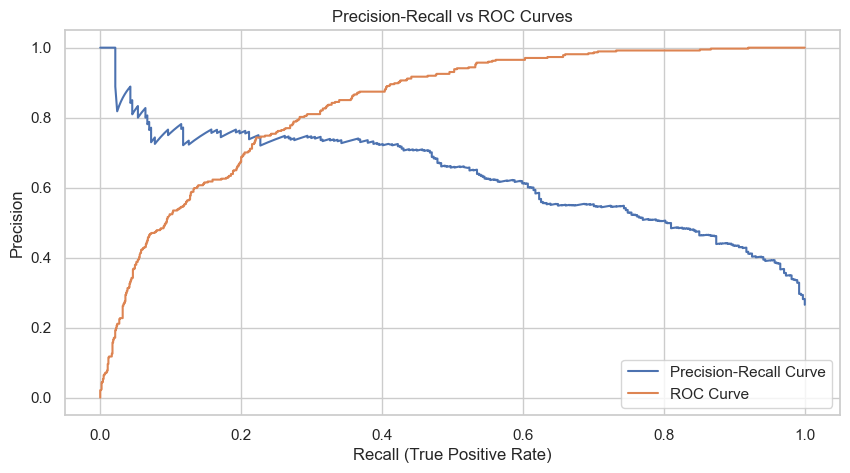

In [ ]:
y_scores_xgb = best_rf_pipeline.predict_proba(X_test_processed)[:, 1]  # Probability of positive class

# Get binary predictions for metrics
y_pred_xgb = best_rf_pipeline.predict(X_test_processed)

# Calculate precision-recall curve
precision_xgb, recall_xgb, thresholds_pr = precision_recall_curve(y_test, y_scores_xgb)

# Calculate ROC curve
fpr_xgb, tpr_xgb, thresholds_roc = roc_curve(y_test, y_scores_xgb)

# Plot both curves
plt.figure(figsize=(10, 5))
plt.plot(recall_xgb, precision_xgb, label='Precision-Recall Curve')
plt.plot(fpr_xgb, tpr_xgb, label='ROC Curve')
plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision')
plt.title('Precision-Recall vs ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

In [58]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical


pipeline_rf_bayes = Pipeline([
    ('preprocessor', preprocessor),
    ('resampler', SMOTE(random_state=42)), # SMOTE instance is fine here
    ('classifier', RandomForestClassifier(
        random_state=42,
        n_jobs=-1
    ))
])


search_spaces_rf_bayes = {

    'resampler__k_neighbors': Integer(3, 7, prior='uniform'),


    'classifier__class_weight': Categorical([None]),
    'classifier__bootstrap': Categorical([False]),

    'classifier__n_estimators': Integer(200, 400, prior='uniform'),
    'classifier__max_depth': Integer(5, 15, prior='uniform'),
    'classifier__max_features': Categorical(['log2']),
    'classifier__min_samples_split': Integer(3, 7, prior='uniform'),
    'classifier__min_samples_leaf': Integer(1, 3, prior='uniform'),
}

n_iterations_rf_bayes = 50 # Number of iterations for Bayesian optimization
scoring_metric = 'f1'
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

bayes_search_rf = BayesSearchCV(
    estimator=pipeline_rf_bayes, # Use the corrected pipeline
    search_spaces=search_spaces_rf_bayes, # Use the corrected search space
    n_iter=n_iterations_rf_bayes,
    scoring=scoring_metric,
    cv=cv_strategy,
    n_jobs=-1,
    refit=True,
    random_state=42,
    verbose=1
)


print(f"\nStarting BayesSearchCV for RandomForest with n_iter={n_iterations_rf_bayes}...")
print(f"Using focused search space based on RandomizedSearch results:")

print(f"  Resampler: SMOTE (tuning k_neighbors)")
print(f"  Class Weight: None")


Starting BayesSearchCV for RandomForest with n_iter=50...
Using focused search space based on RandomizedSearch results:
  Resampler: SMOTE (tuning k_neighbors)
  Class Weight: None


In [ ]:
bayes_search_rf.fit(X_train_processed, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


ValueError: Specifying the columns using strings is only supported for dataframes.

In [55]:
print(random_search_rf.best_params_)
print(f"\nBest Cross-Validation {scoring_metric.upper()} Score (Random Forest): {random_search_rf.best_score_:.4f}")

# Store the best RF estimator
best_rf_pipeline = random_search_rf.best_estimator_

{'resampler__k_neighbors': 5, 'resampler': SMOTE(random_state=42), 'classifier__n_estimators': 300, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'log2', 'classifier__max_depth': 10, 'classifier__class_weight': None, 'classifier__bootstrap': False}

Best Cross-Validation F1 Score (Random Forest): 0.6322


In [ ]:
y_pred_rf = best_rf_pipeline.predict(X_test_processed)
y_pred_proba_rf = best_rf_pipeline.predict_proba(X_test_processed)[:, 1]
model_results = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1': f1_score(y_test, y_pred_rf),
    'ROC_AUC': roc_auc_score(y_test, y_pred_proba_rf),
    'ConfusionMatrix': confusion_matrix(y_test, y_pred_rf),
    'Report': classification_report(y_test, y_pred_rf),
    'Proba': y_pred_proba_rf,
    'Pipeline': best_rf_pipeline
}
print('Accuracy:', model_results['Accuracy'])
print('Precision:', model_results['Precision'])
print('Recall:', model_results['Recall'])
print('F1:', model_results['F1'])
print('ROC_AUC:', model_results['ROC_AUC'])
print("Confusion Matrix:\n", model_results['ConfusionMatrix'])

Accuracy: 0.7693399574166075
Precision: 0.5522388059701493
Recall: 0.6925133689839572
F1: 0.6144721233689205
ROC_AUC: 0.8368208943656513
Confusion Matrix:
 [[825 210]
 [115 259]]


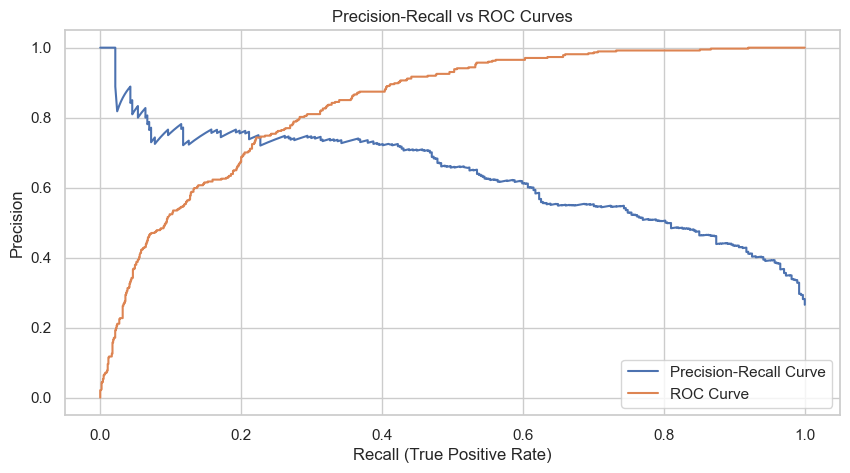

In [ ]:
y_scores_xgb = best_rf_pipeline.predict_proba(X_test_processed)[:, 1]  # Probability of positive class

# Get binary predictions for metrics
y_pred_xgb = best_rf_pipeline.predict(X_test_processed)

# Calculate precision-recall curve
precision_xgb, recall_xgb, thresholds_pr = precision_recall_curve(y_test, y_scores_xgb)

# Calculate ROC curve
fpr_xgb, tpr_xgb, thresholds_roc = roc_curve(y_test, y_scores_xgb)

# Plot both curves
plt.figure(figsize=(10, 5))
plt.plot(recall_xgb, precision_xgb, label='Precision-Recall Curve')
plt.plot(fpr_xgb, tpr_xgb, label='ROC Curve')
plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision')
plt.title('Precision-Recall vs ROC Curves')
plt.legend()
plt.grid(True)
plt.show()